# This notebook demonstrates how to train class version of buddi4 model from buddi_v2

In [1]:
import os
import sys
import pathlib
import yaml
import subprocess
import re
from collections import defaultdict

import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
import umap.umap_ as umap
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from matplotlib_venn import venn2, venn3
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.losses import CategoricalCrossentropy, MeanAbsoluteError

2025-05-05 15:58:41.062758: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-05 15:58:41.071527: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746482321.080636   85816 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746482321.083539   85816 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1746482321.091495   85816 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
SAMPLE_ID_COL = 'sample_id'
STIM_COL = 'stim'
GENE_ID_COL = 'gene_ids'
TECH_COL = 'samp_type'

## Add buddi_v2 software to path

In [3]:
# Get the root directory of the analysis repository
REPO_ROOT = subprocess.run(
    ["git", "rev-parse", "--show-toplevel"], capture_output=True, text=True
).stdout.strip()
REPO_ROOT = pathlib.Path(REPO_ROOT)
BUDDI_PATH = REPO_ROOT / "src"

sys.path.insert(0, str(BUDDI_PATH))

from buddi_v2.dataset.buddi4_dataset import get_supervised_dataset, get_unsupervised_dataset
from buddi_v2.models.buddi4 import fit_buddi4
from buddi_v2.models.components.losses import kl_loss
from buddi_v2.models.buddi4_class import BuDDI4
from buddi_v2.plotting.plot_latent_space import plot_latent_spaces_buddi4
from buddi_v2.plotting.plot_data import plot_data

I0000 00:00:1746482322.127818   85816 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6423 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2070 SUPER, pci bus id: 0000:01:00.0, compute capability: 7.5


## Pre-Processing Output

In [4]:
## Input data path
DATA_PATH = pathlib.Path('.').absolute() / 'example_data'
assert DATA_PATH.exists()
PREPROCESS_OUTPUT_PATH = pathlib.Path('.').absolute() / 'example_data' / 'preprocessed_data'
assert PREPROCESS_OUTPUT_PATH.exists(), f"Preprocessed data path {PREPROCESS_OUTPUT_PATH} does not exist."

PREPROCESS_SC_AUGMENTED_OUTPUT_PATH = PREPROCESS_OUTPUT_PATH / 'sc_augmented'
assert PREPROCESS_SC_AUGMENTED_OUTPUT_PATH.exists()

CIBERSORTX_SIG_GENE_FILE = DATA_PATH / 'cibersort_liver' /\
    'CIBERSORTx_Job20_all-liver_0_cybersort_sig_inferred_phenoclasses.CIBERSORTx_Job20_all-liver_0_cybersort_sig_inferred_refsample.bm.K999.txt'
assert CIBERSORTX_SIG_GENE_FILE.exists()

PREPROCESS_BULK_FORMAT_PATH = PREPROCESS_OUTPUT_PATH / 'bulk_formatted'
assert PREPROCESS_BULK_FORMAT_PATH.exists()

### Read cibersortx sig genes

In [5]:
cibersortx_sig_df = pd.read_csv(CIBERSORTX_SIG_GENE_FILE, sep='\t', header=0)
cibersortx_sig_genes = cibersortx_sig_df['NAME'].values.tolist()
print(f"{len(cibersortx_sig_genes)} signature genes from CIBERSORTx")

2194 signature genes from CIBERSORTx


### Read gene id pkl file for single cell and psuedobulk and find intersection

Number of bulk genes: 54352
Number of single cell genes: 13924
Number of genes in intersection of single cell and bulk: 12618
Number of CIBERSORTx signature genes dropped due to not in intersection: 284


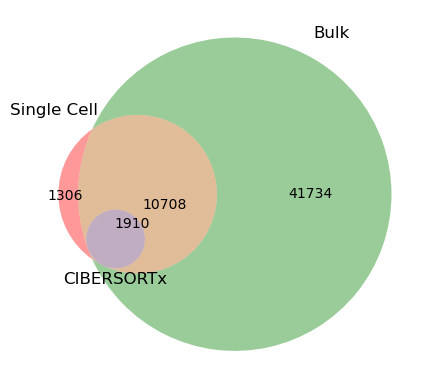

In [6]:
bulk_gene_file = PREPROCESS_BULK_FORMAT_PATH.glob('*_genes.pkl')
bulk_gene_file = list(bulk_gene_file)
assert len(bulk_gene_file) == 1, f"Expected one bulk gene file, found {len(bulk_gene_file)}"
bulk_genes = pd.read_pickle(bulk_gene_file[0])
print(f"Number of bulk genes: {len(bulk_genes)}")

sc_gene_file = PREPROCESS_SC_AUGMENTED_OUTPUT_PATH.glob('*_genes.pkl')
sc_gene_file = list(sc_gene_file)
assert len(sc_gene_file) == 1, f"Expected one sc gene file, found {len(sc_gene_file)}"
sc_genes = pd.read_pickle(sc_gene_file[0])
print(f"Number of single cell genes: {len(sc_genes)}")

# Intersect the genes
sc_bulk_intersection_genes = set(sc_genes) & set(bulk_genes)
sc_bulk_intersection_genes = list(sc_bulk_intersection_genes)
print(f"Number of genes in intersection of single cell and bulk: {len(sc_bulk_intersection_genes)}")

# drop cibersortx signature genes that are not in the sc bulk intersection
cibersortx_drop_genes = set(cibersortx_sig_genes) - set(sc_bulk_intersection_genes)
print(f"Number of CIBERSORTx signature genes dropped due to not in intersection: {len(cibersortx_drop_genes)}")
cibersortx_sig_genes = set(cibersortx_sig_genes).intersection(sc_bulk_intersection_genes)
cibersortx_sig_genes = list(cibersortx_sig_genes)

venn3(
    [
        set(sc_genes),
        set(bulk_genes),
        set(cibersortx_sig_genes)
    ],
    set_labels=['Single Cell', 'Bulk', 'CIBERSORTx']
)

### Preprocessed Bulk

In [7]:
formatted_bulk_files = list(PREPROCESS_BULK_FORMAT_PATH.glob('*.h5ad'))
assert len(formatted_bulk_files) > 0, f"No formatted bulk files found in {PREPROCESS_BULK_FORMAT_PATH}"

processed_bulk = sc.read(formatted_bulk_files[0]) 

bulk_sample_ids = processed_bulk.obs[SAMPLE_ID_COL].unique()
n_bulk_samples = len(bulk_sample_ids)
print(f"Number of bulk samples: {n_bulk_samples}")

bulk_stims = processed_bulk.obs[STIM_COL].unique()
n_bulk_stims = len(bulk_stims)
print(f"Number of bulk stims: {n_bulk_stims}")

## Subset the bulk data to only include the intersection genes
processed_bulk = processed_bulk[
    :, 
    processed_bulk.var[GENE_ID_COL].isin(sc_bulk_intersection_genes)]

X_bulk_train = pd.DataFrame(
    processed_bulk.X,
    index=processed_bulk.obs[SAMPLE_ID_COL],
    columns=processed_bulk.var[GENE_ID_COL]
)

meta_bulk_train = processed_bulk.obs.loc[:,[SAMPLE_ID_COL, STIM_COL]]
meta_bulk_train['isTraining'] = 'Train'
meta_bulk_train['cell_prop_type'] = 'bulk'
meta_bulk_train['cell_type'] = 'bulk'
meta_bulk_train['samp_type'] = 'bulk'

Number of bulk samples: 49
Number of bulk stims: 2


### Preprocessed single cell

In [8]:
pseudobulk_files = list(PREPROCESS_SC_AUGMENTED_OUTPUT_PATH.glob('*_splits.pkl'))
assert len(pseudobulk_files) > 0, f"No pseudobulk files found in {PREPROCESS_SC_AUGMENTED_OUTPUT_PATH}"

pattern = re.compile(r'^(.*)_((?:Train)|(?:Test))_((?:meta)|(?:prop)|(?:pseudo))_splits\.pkl$')

# Temporary dictionary to group by sample_id
temp_dict = defaultdict(lambda: defaultdict(dict))

for path in pseudobulk_files:
    file = path.name
    match = pattern.match(file)
    if match:
        sample_id, datasplit, datatype = match.groups()
        temp_dict[datasplit][sample_id][datatype] = path

# Organizing the sorted results
grouped_files = {
    "Train": {"meta": [], "prop": [], "pseudo": []},
    "Test": {"meta": [], "prop": [], "pseudo": []}
}

# Sort within each datasplit by sample_id and organize the lists
for datasplit in ["Train", "Test"]:
    sorted_samples = sorted(temp_dict[datasplit].keys())  # Sort by sample_id
    for sample_id in sorted_samples:
        for datatype in ["meta", "prop", "pseudo"]:
            print(f"Found {datatype} file for {datasplit} sample {sample_id}")
            if datatype in temp_dict[datasplit][sample_id]:
                grouped_files[datasplit][datatype].append(temp_dict[datasplit][sample_id][datatype])

# Train datasplit
meta_sc_train = pd.concat(
    [pd.read_pickle(file) for file in grouped_files['Train']['meta']]
)
meta_sc_train['isTraining'] = 'Train'
Y_sc_train = pd.concat(
    [pd.read_pickle(file) for file in grouped_files['Train']['prop']]
)
X_sc_train = pd.concat(
    [pd.read_pickle(file).loc[:, sc_bulk_intersection_genes] for file in grouped_files['Train']['pseudo']]
)

_n_samples = meta_sc_train[SAMPLE_ID_COL].nunique()
print(f"Number of train single cell samples: {_n_samples}")

_n_stims = meta_sc_train[STIM_COL].nunique()
print(f"Number of train single cell stims: {_n_stims}")

# Test datasplit
meta_sc_test = pd.concat(
    [pd.read_pickle(file) for file in grouped_files['Test']['meta']]
)
meta_sc_test['isTraining'] = 'Test'
Y_sc_test = pd.concat(
    [pd.read_pickle(file) for file in grouped_files['Test']['prop']]
)
X_sc_test = pd.concat(
    [pd.read_pickle(file).loc[:, sc_bulk_intersection_genes] for file in grouped_files['Test']['pseudo']]
)

_n_samples = meta_sc_test[SAMPLE_ID_COL].nunique()
print(f"Number of test single cell samples: {_n_samples}")
_n_stims = meta_sc_test[STIM_COL].nunique()
print(f"Number of test single cell stims: {_n_stims}")

Found meta file for Train sample liver_30-M-5_male
Found prop file for Train sample liver_30-M-5_male
Found pseudo file for Train sample liver_30-M-5_male
Found meta file for Test sample liver_18-F-51_female
Found prop file for Test sample liver_18-F-51_female
Found pseudo file for Test sample liver_18-F-51_female
Number of train single cell samples: 1
Number of train single cell stims: 1
Number of test single cell samples: 1
Number of test single cell stims: 1


### Concatenate X, Y, Perform Gene Feature Selection, then Encode Metadata

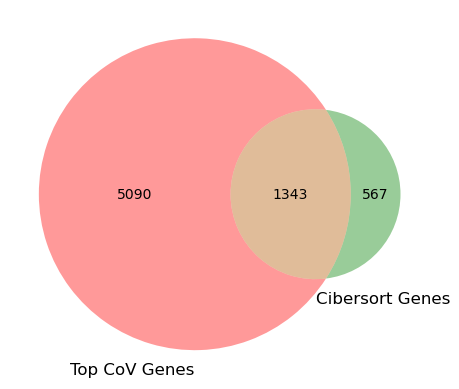

(3649, 7000)


In [9]:
# Generate place holder for bulk proportion (not used)
Y_bulk_dummy = pd.DataFrame(
    np.zeros((X_bulk_train.shape[0], Y_sc_train.shape[1])),
    columns=Y_sc_train.columns
)

X_concat = pd.concat([X_bulk_train, X_sc_train, X_sc_test])
Y_concat = pd.concat([Y_bulk_dummy, Y_sc_train, Y_sc_test])
meta_concat = pd.concat([meta_bulk_train, meta_sc_train, meta_sc_test])

# save gene and cell type names
X_gene_names = X_concat.columns.to_list()
Y_cell_type_names = Y_concat.columns.to_list()

## get the top variable genes
X_colmean = X_concat.values.mean(axis=0) # mean across samples
X_colvar = X_concat.values.var(axis=0) # variance across samples
# coefficient of variation which is the var to mean ratio
X_CoV = np.array(np.divide(X_colvar, X_colmean+0.001)) 

# need to get the genes such that
# the union of the highly variable and the
# CIBERSORTx genes are 7000 total
num_genes_found = False

gene_df = pd.DataFrame(X_gene_names, columns=['gene'])

# start with top 7000 genes by CoV
initial_count = 7000
while not num_genes_found:
    # retrieve the top initial_count genes by CoV
    idx_top = np.argpartition(X_CoV, -initial_count)[-initial_count:]
    # get gene names from idx_top
    top_gene_df = gene_df.iloc[idx_top]

    # produce the union of the top genes and the cibersort genes
    CoV_only = np.union1d(top_gene_df, cibersortx_sig_genes)

    # check if the union is 7000
    if len(CoV_only) == 7000:
        num_genes_found = True
    else:
        # if not decrement the top CoV gene to retrieve by 1
        # in the next iteration, there will be two possibilities
        # 1. the union will have one less gene due to the removed gene being only in the CoV genes
        # 2. the union will have the same number of genes as this iteration due to the removed 
        #    gene being also present in CIBERSORTx genes
        # keep running this loop until the union has 7000 genes
        initial_count = initial_count -1

idx_top = np.argpartition(X_CoV, -initial_count)[-initial_count:] # num_genes to get 7000
gene_df = gene_df.iloc[idx_top]
venn2([set(gene_df.values.flatten()), 
       set(cibersortx_sig_genes)], 
       set_labels = ('Top CoV Genes', 'Cibersort Genes'))
plt.show()

feature_select_genes = np.union1d(gene_df, cibersortx_sig_genes)

# to numpy matrix
X = X_concat.loc[:,feature_select_genes].to_numpy()
print(X.shape)

Y = Y_concat.to_numpy()

FIELDS_TO_ENCODE = [SAMPLE_ID_COL, STIM_COL, TECH_COL]

encoded = {}

for field in FIELDS_TO_ENCODE:
    encoder = OneHotEncoder(dtype=int)
    encoded[field] = pd.DataFrame(
        encoder.fit_transform(meta_concat.loc[:,[field]]).toarray(),
        columns=encoder.get_feature_names_out([field])
    )

In [10]:
n_x = X.shape[1]
n_y = Y.shape[1]
n_labels = encoded[SAMPLE_ID_COL].shape[1]
n_stims = encoded[STIM_COL].shape[1]
n_samp_types = encoded[TECH_COL].shape[1]

print(f"Number of genes: {n_x}")
print(f"Number of cell types: {n_y}")
print(f"Number of samples: {n_labels}")
print(f"Number of stimulations: {n_stims}")
print(f"Number of sample types: {n_samp_types}")

Number of genes: 7000
Number of cell types: 8
Number of samples: 51
Number of stimulations: 2
Number of sample types: 2


### Normalize Expression

In [11]:
## library size normalization
expected_libsizes = 1e6

libsizes = np.sum(X, axis=1, keepdims=True)
libsizes[libsizes == 0] = 1
X_norm = X / libsizes * expected_libsizes

## normalize within sample
clip_upper = np.quantile(X_norm, 0.9)
X_full = np.clip(X_norm, 0, clip_upper)
scaler = MinMaxScaler()
scaler.fit(X_full)

# now normalize with the scaler trained on the 
# training data
X_full = np.clip(X_full, 0, clip_upper)
X_full = scaler.transform(X_full)

### Visualize Augmented Data

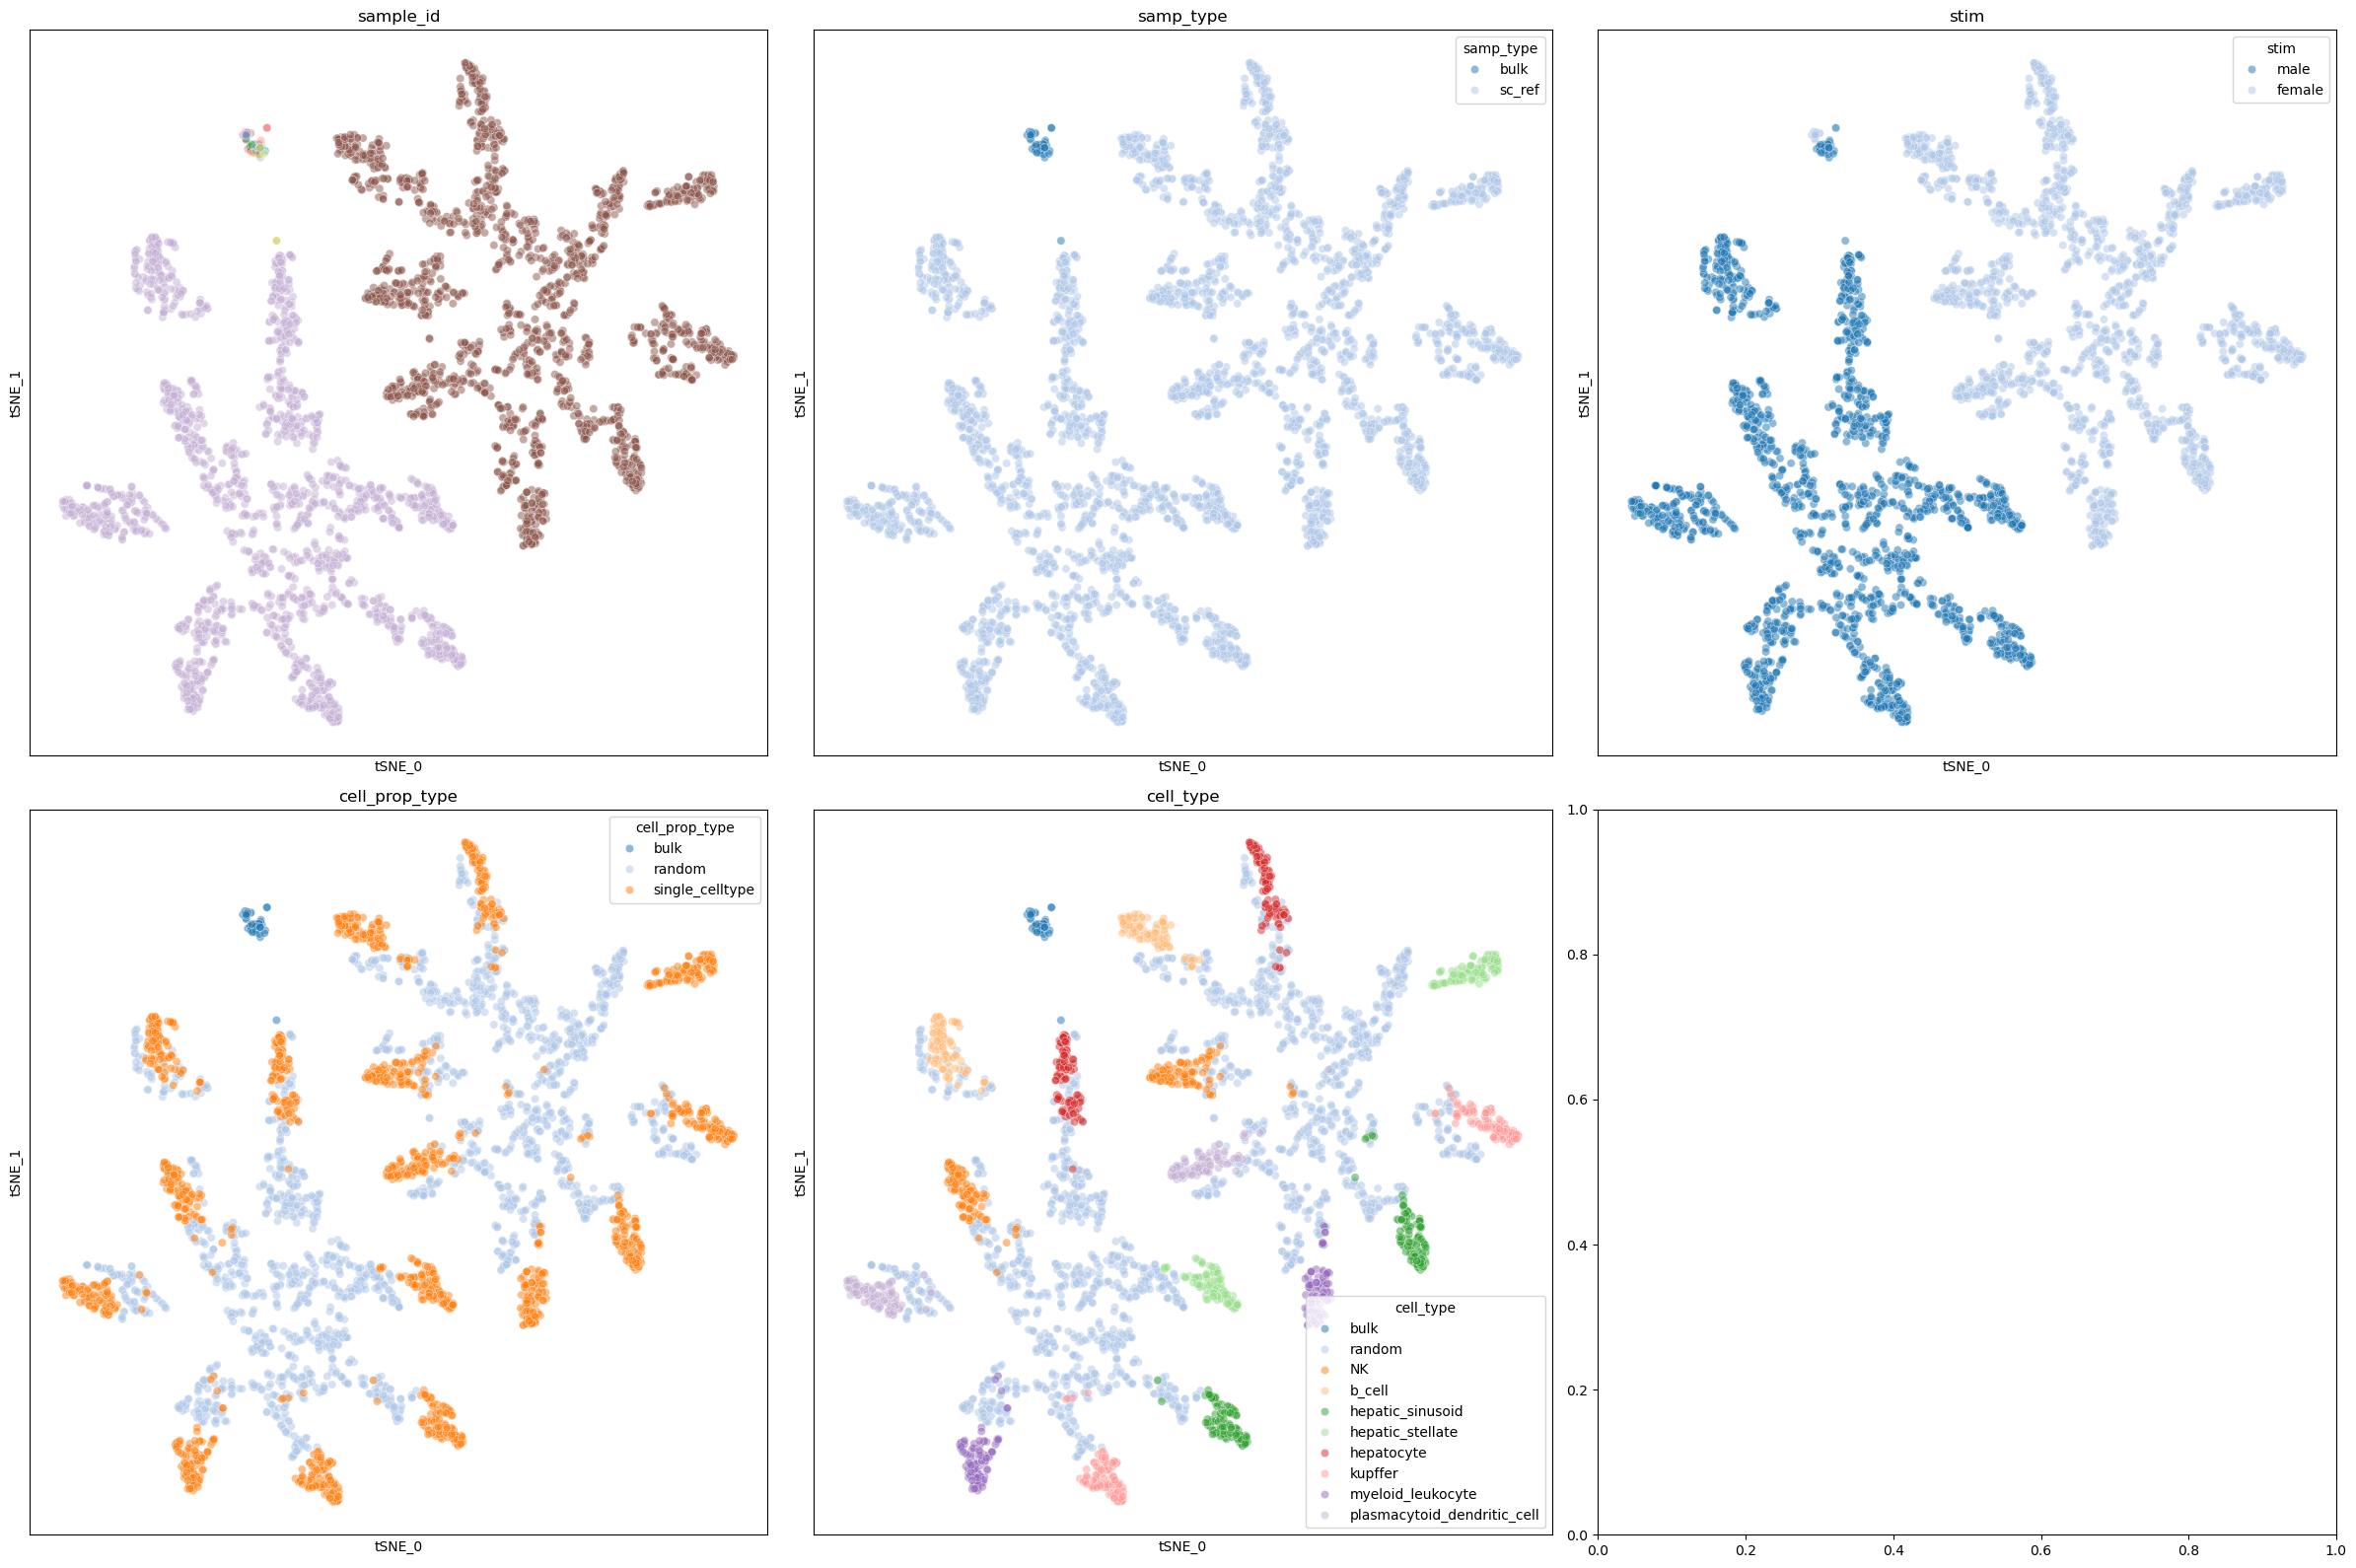

In [12]:
plot_data(
    X_full,
    meta_concat,
    panel_width=8,
    show_plot=True
)

### Supervised vs Unsupervised split & Dataset Generation

Unsupervised/Supervised Data split need to be handled manually

In [13]:
idx_train = np.where(meta_concat.isTraining=="Train")[0] 
idx_bulk = np.where(meta_concat.samp_type == "bulk")[0]
idx_sc = np.where(meta_concat.samp_type != "bulk")[0]

# for unknown proportions; 
# this is bulks used in training
idx_bulk_train = np.intersect1d(idx_bulk, idx_train)
np.random.shuffle(idx_bulk_train) # shuffle the indices randomly

X_unkp = X_full[idx_bulk_train,]
label_unkp = encoded[SAMPLE_ID_COL].values[idx_bulk_train,]
drug_unkp = encoded[STIM_COL].values[idx_bulk_train,]
bulk_unkp = encoded[TECH_COL].values[idx_bulk_train,]
y_unkp = Y[idx_bulk_train,]

# for known proportions
idx_sc_train = np.intersect1d(idx_sc, idx_train)
np.random.shuffle(idx_sc_train) # shuffle the indices randomly

X_kp = X_full[idx_sc_train,]
label_kp = encoded[SAMPLE_ID_COL].values[idx_sc_train,]
drug_kp = encoded[STIM_COL].values[idx_sc_train,]
bulk_kp = encoded[TECH_COL].values[idx_sc_train,]
y_kp = Y[idx_sc_train,]

Generating Tensorflow `dataset` objects for BuDDI4 training (**note** `ds_sup` and `ds_unsup` do not work with plotting or model inference out of the box), use raw data (e.g. `X_kp`, `X_unkp`) instead for these purposes.

In [14]:
ds_sup = get_supervised_dataset(
    X_known_prop=X_kp,
    Y_known_prop=y_kp,
    label_known_prop=label_kp,
    stim_known_prop=drug_kp,
    samp_type_known_prop=bulk_kp,
)
print(f"Number of entries in supervised dataset: {ds_sup.cardinality().numpy()}")
ds_sup_batch_x, ds_sup_batch_y = next(iter(ds_sup))

ds_unsup = get_unsupervised_dataset(
    X_unknown_prop=X_unkp,
    label_unknown_prop=label_unkp,
    stim_unknown_prop=drug_unkp,
    samp_type_unknown_prop=bulk_unkp,
)
print(f"Number of entries in unsupervised dataset: {ds_unsup.cardinality().numpy()}")

print("\nTake a peek at the dataset generator return:\n")

ds_sup_batch_input, ds_sup_batch_target = next(iter(ds_sup.batch(16).take(1)))
ds_sup_batch_x, ds_sup_batch_y = ds_sup_batch_input
print(f"Supervised batch x shape: {ds_sup_batch_x.shape}")
print(f"Supervised batch y shape: {ds_sup_batch_y.shape}")
ds_sup_batch_target_x, _, _, _, _, ds_sup_batch_label, ds_sup_batch_stim, ds_sup_batch_samp_type, ds_sup_batch_target_y = ds_sup_batch_target
print(f"Supervised batch target x shape: {ds_sup_batch_target_x.shape}")
print(f"Supervised batch target y shape: {ds_sup_batch_target_y.shape}")
print(f"Supervised batch label shape: {ds_sup_batch_label.shape}")
print(f"Supervised batch stim shape: {ds_sup_batch_stim.shape}")
print(f"Supervised batch samp_type shape: {ds_sup_batch_samp_type.shape}")

print("\n")

ds_unsup_batch_input, ds_unsup_batch_target = next(iter(ds_unsup.batch(16).take(1)))
ds_unsup_batch_x, = ds_unsup_batch_input
print(f"Unsupervised batch x shape: {ds_unsup_batch_x.shape}")
ds_unsup_batch_target_x, _, _, _, _, ds_unsup_batch_label, ds_unsup_batch_stim, ds_unsup_batch_samp_type, _ = ds_unsup_batch_target
print(f"Unsupervised batch target x shape: {ds_unsup_batch_target_x.shape}")
print(f"Unsupervised batch label shape: {ds_unsup_batch_label.shape}")
print(f"Unsupervised batch stim shape: {ds_unsup_batch_stim.shape}")
print(f"Unsupervised batch samp_type shape: {ds_unsup_batch_samp_type.shape}")

Number of entries in supervised dataset: 1800
Number of entries in unsupervised dataset: 49

Take a peek at the dataset generator return:

Supervised batch x shape: (16, 7000)
Supervised batch y shape: (16, 8)
Supervised batch target x shape: (16, 7000)
Supervised batch target y shape: (16, 8)
Supervised batch label shape: (16, 51)
Supervised batch stim shape: (16, 2)
Supervised batch samp_type shape: (16, 2)


Unsupervised batch x shape: (16, 7000)
Unsupervised batch target x shape: (16, 7000)
Unsupervised batch label shape: (16, 51)
Unsupervised batch stim shape: (16, 2)
Unsupervised batch samp_type shape: (16, 2)


## BuDDI Training

### Instantiate Model

In [15]:
obj = BuDDI4(
    n_x=n_x,
    n_y=n_y,
    n_labels=n_labels,
    n_stims=n_stims,
    n_samp_types=n_samp_types,
    z_dim=64,
    encoder_hidden_dim=512,
    decoder_hidden_dim=512,
    activation='relu',
    output_activation='sigmoid',
)

### Configure Losses

In [16]:
ALPHA = 100.0
ALPHA_X = 1.0

BETA = 100.0
BETA_SLACK = 0.1

obj.set_reconstruction_loss(
    fn=MeanAbsoluteError(reduction='sum'),
    weight=ALPHA_X,
)
obj.set_encoder_loss(
    branch='label',
    fn=kl_loss,
    weight=BETA,    
)
obj.set_encoder_loss(
    branch='stim',
    fn=kl_loss,
    weight=BETA,    
)
obj.set_encoder_loss(
    branch='samp_type',
    fn=kl_loss,
    weight=BETA,    
)
obj.set_encoder_loss(
    branch='slack',
    fn=kl_loss,
    weight=BETA_SLACK,
)
obj.set_predictor_loss(
    branch='label',
    fn=CategoricalCrossentropy(reduction='sum'),
    weight=ALPHA
)
obj.set_predictor_loss(
    branch='stim',
    fn=CategoricalCrossentropy(reduction='sum'),
    weight=ALPHA
)
obj.set_predictor_loss(
    branch='samp_type',
    fn=CategoricalCrossentropy(reduction='sum'),
    weight=ALPHA
)
obj.set_prop_estimator_loss(
    fn=CategoricalCrossentropy(reduction='sum'),
    weight=ALPHA,
)

obj.print_loss_table()

Loss Name       Function                    Weight 
---------------------------------------------------
x_hat_sup       MeanAbsoluteError           1.0    
x_hat_unsup     MeanAbsoluteError           1.0    
kl_label        kl_loss                     100.0  
kl_stim         kl_loss                     100.0  
kl_samp_type    kl_loss                     100.0  
kl_slack        kl_loss                     0.1    
label_pred      CategoricalCrossentropy     100.0  
stim_pred       CategoricalCrossentropy     100.0  
samp_type_pred  CategoricalCrossentropy     100.0  
y_hat           CategoricalCrossentropy     100.0  
y_dummy         unsupervised_dummy_loss_fn  0.0    


### Compile

In [17]:
obj.compile(optimizer=Adam(learning_rate=0.0005))

### Visualize connection

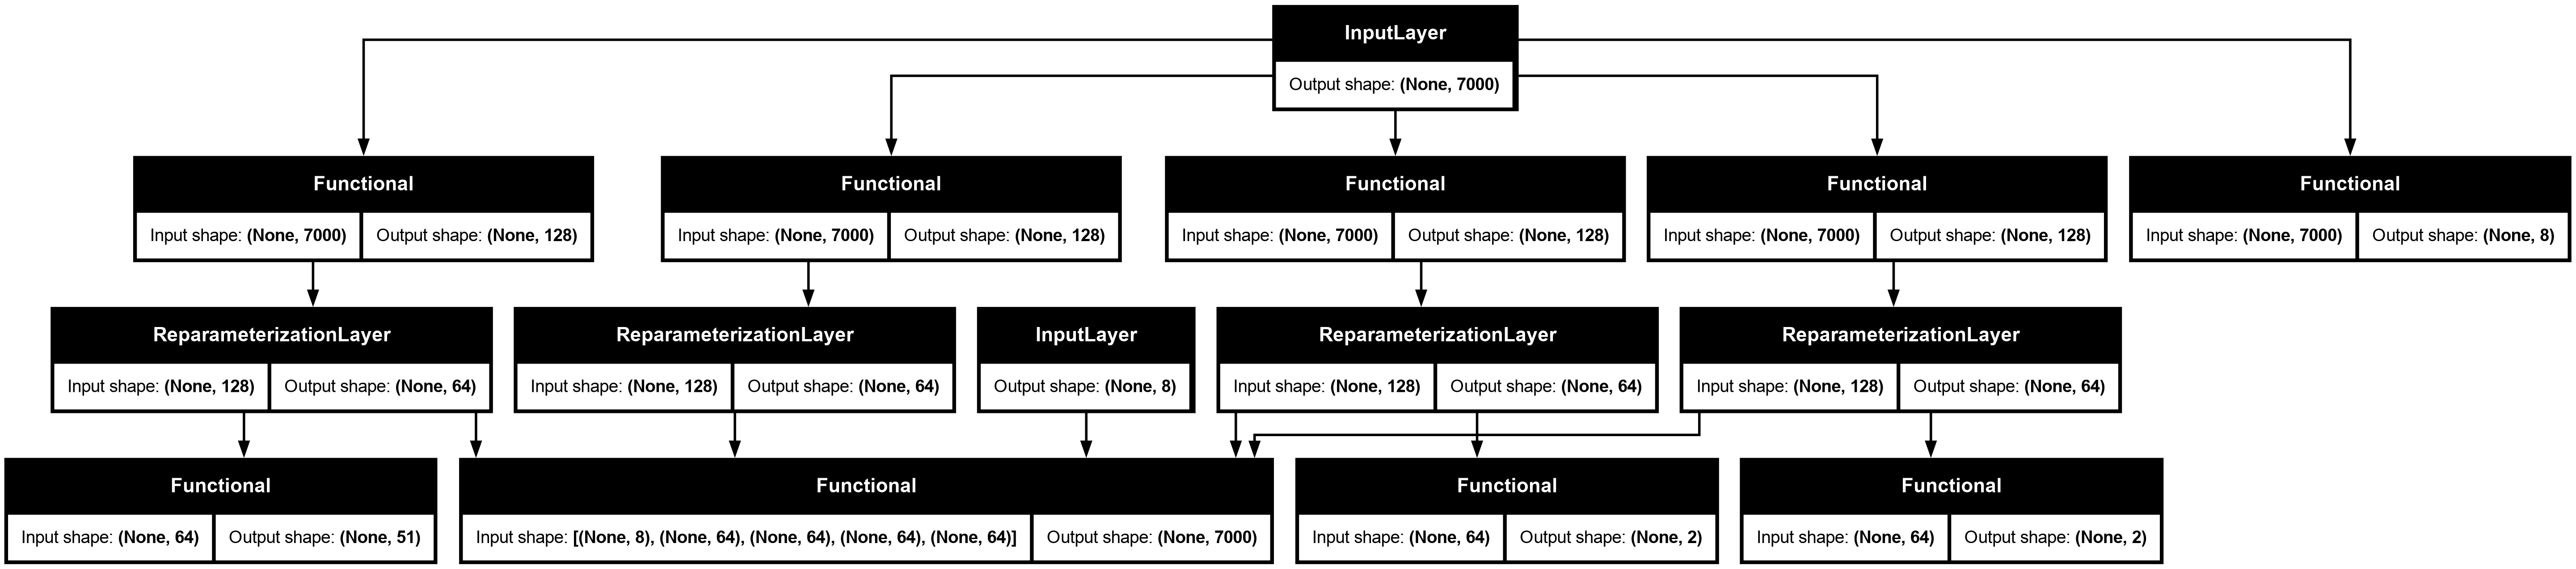

In [18]:
plot_model(obj.sup_model, show_shapes=True)

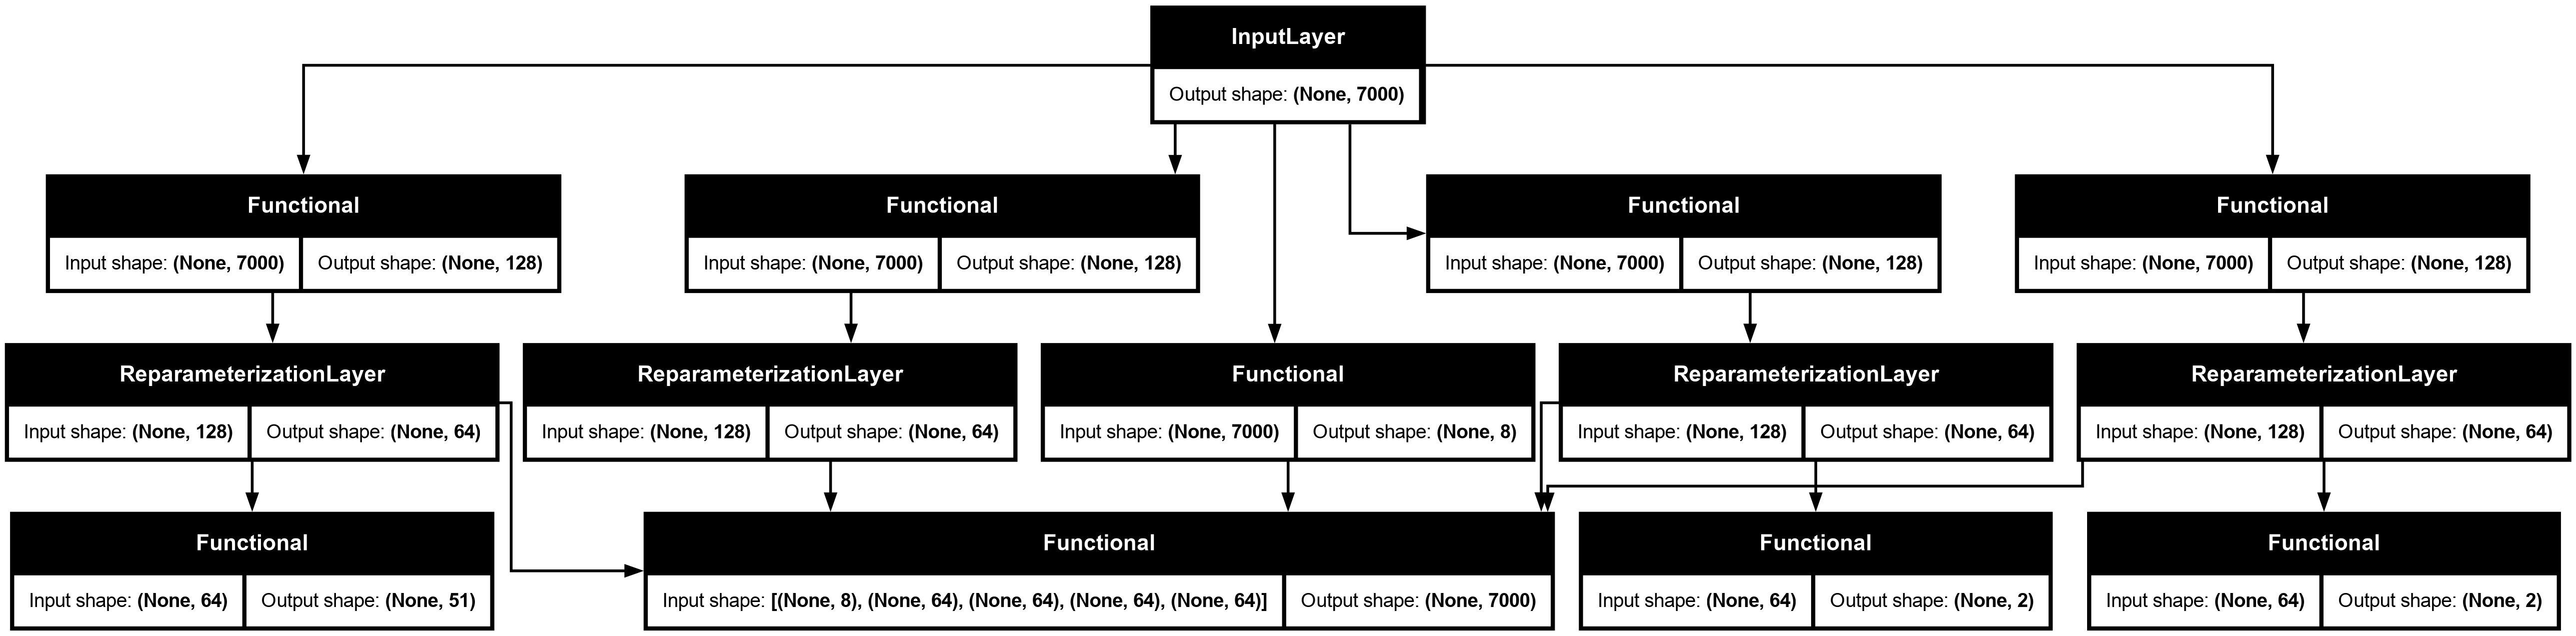

In [19]:
plot_model(obj.unsup_model, show_shapes=True)

In [20]:
!rm model.png

### Train Model

In [21]:
all_loss_df = fit_buddi4(
    obj.sup_model, obj.unsup_model, 
    ds_sup, ds_unsup, 
    epochs=10, batch_size=16, prefetch=True
)

Epoch 1/10:   0%|          | 0/113 [00:00<?, ?it/s]WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
I0000 00:00:1746482333.653948   85816 service.cc:152] XLA service 0x61786ba30bc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746482333.653961   85816 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 2070 SUPER, Compute Capability 7.5
2025-05-05 15:58:53.709429: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1746482334.068915   85816 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1746482335.854188   85816 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
Epoch 10/10: 100%|██████████| 113/113 [00:06<00:00, 17.13it/s]

Training complete!


### Examine Reconstruction

**Optional**: For seeded determinstic behavior, do:
```python
obj.set_reparam_deterministic(deterministic=True, seed=42)
```
To go back to stochastic, simply do:
```python
obj.set_reparam_deterministic(deterministic=False)
```

In [22]:
(
    x_hat,
    z_param_label,
    z_param_stim,
    z_param_samp_type,
    z_param_slack,
    pred_label,
    pred_stim,
    pred_samp_type,
    y_hat
) = obj.unsup_model(
    ds_unsup_batch_input
)
print(f"Predicted x shape: {x_hat.shape}")
print(f"Predicted z_param_label shape: {z_param_label.shape}")
print(f"Predicted z_param_stim shape: {z_param_stim.shape}")
print(f"Predicted z_param_samp_type shape: {z_param_samp_type.shape}")
print(f"Predicted z_param_slack shape: {z_param_slack.shape}")
print(f"Predicted pred_label shape: {pred_label.shape}")
print(f"Predicted pred_stim shape: {pred_stim.shape}")
print(f"Predicted pred_samp_type shape: {pred_samp_type.shape}")
print(f"Predicted y_hat shape: {y_hat.shape}")

Predicted x shape: (16, 7000)
Predicted z_param_label shape: (16, 128)
Predicted z_param_stim shape: (16, 128)
Predicted z_param_samp_type shape: (16, 128)
Predicted z_param_slack shape: (16, 128)
Predicted pred_label shape: (16, 51)
Predicted pred_stim shape: (16, 2)
Predicted pred_samp_type shape: (16, 2)
Predicted y_hat shape: (16, 8)


/home/weishanli/anaconda3/envs/buddi_conda/lib/python3.9/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['unsup_X']
Received: inputs=Tensor(shape=(1000, 7000))
  warnings.warn(msg)


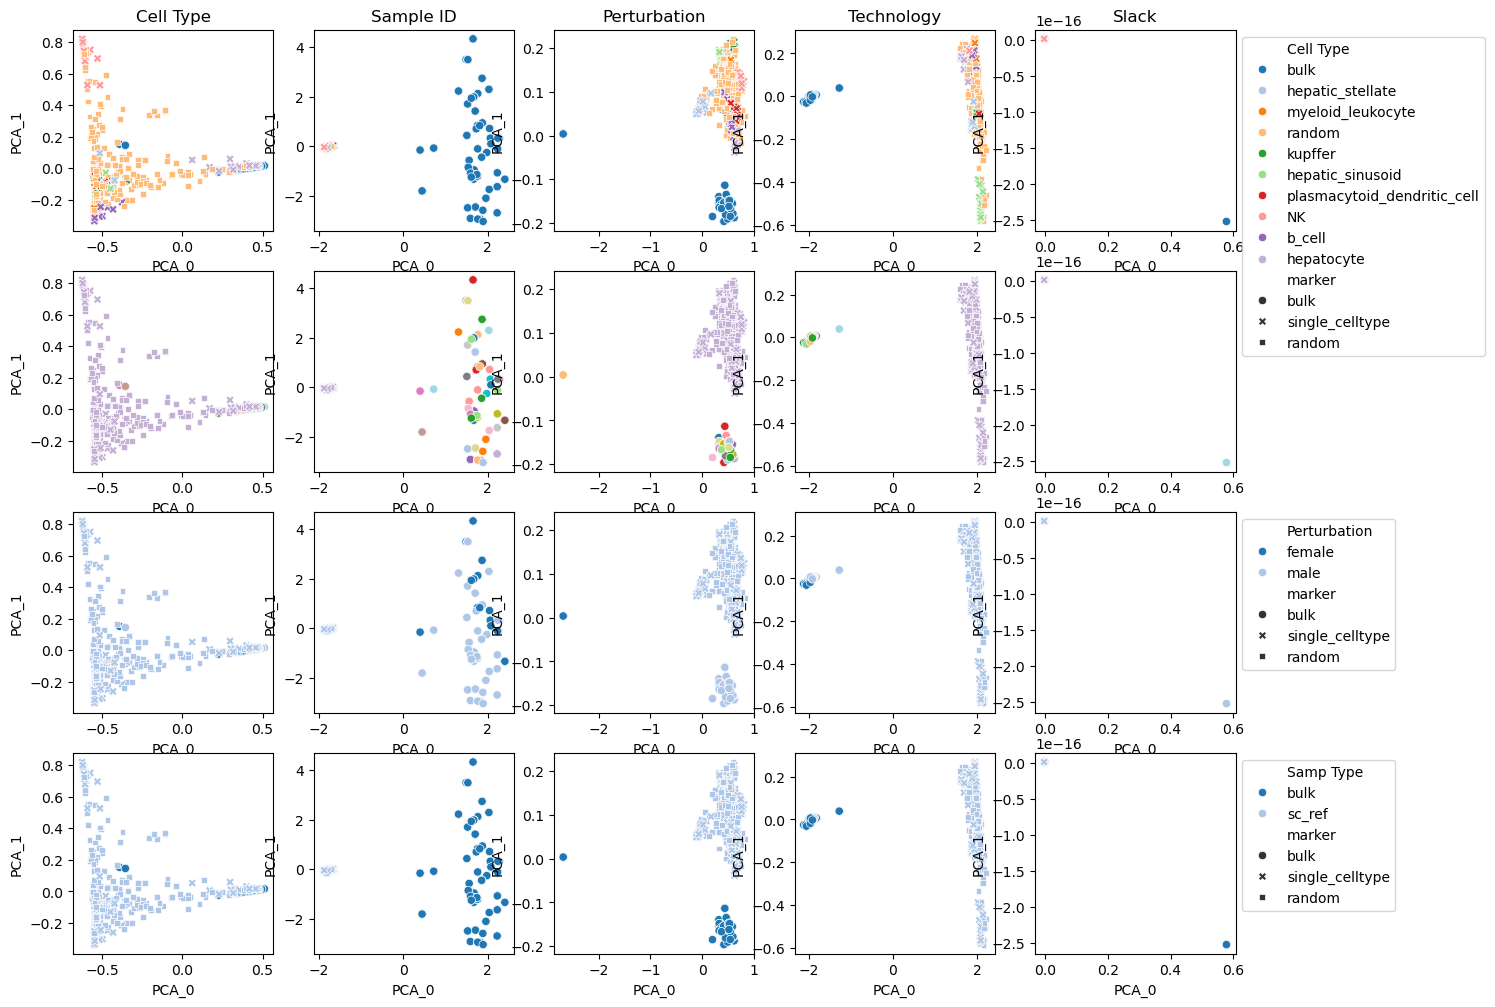

In [23]:
# get the training pseudobulks
idx_tmp_bulk = np.where(np.logical_and(meta_concat.isTraining == "Train", meta_concat.samp_type == "sc_ref"))[0]
idx_tmp_bulk = np.random.choice(idx_tmp_bulk, 500, replace=True)

# get the real bulks
idx_tmp = np.where(np.logical_and(meta_concat.isTraining == "Train", meta_concat.samp_type == "bulk"))[0]
idx_tmp = np.random.choice(idx_tmp, 500, replace=True)

# concatenate so we have them all
idx_tmp = np.concatenate((idx_tmp, idx_tmp_bulk))

X_tmp = X_full[idx_tmp,]
meta_tmp = meta_concat.iloc[idx_tmp,]

cell_types = list(Y_concat.columns)
Y_tmp = Y[idx_tmp,]
idx_sc_prop = np.where(meta_tmp.cell_prop_type == "single_celltype")[0]
cell_type_labels = [cell_types[i] for i in np.argmax(Y_tmp[idx_sc_prop, :], axis=1)]
cell_type_col = meta_tmp.loc[:,'cell_prop_type'].values.copy()
cell_type_col[idx_sc_prop] = cell_type_labels
meta_tmp.loc[:,'cell_type'] = cell_type_col

_ = plot_latent_spaces_buddi4(
    obj.unsup_model,
    X_tmp,
    meta_tmp,
    type='PCA',
    alpha=1,    
    panel_width=3,
    show_plot=True,
    save_path=None,
    palette="tab20",
)

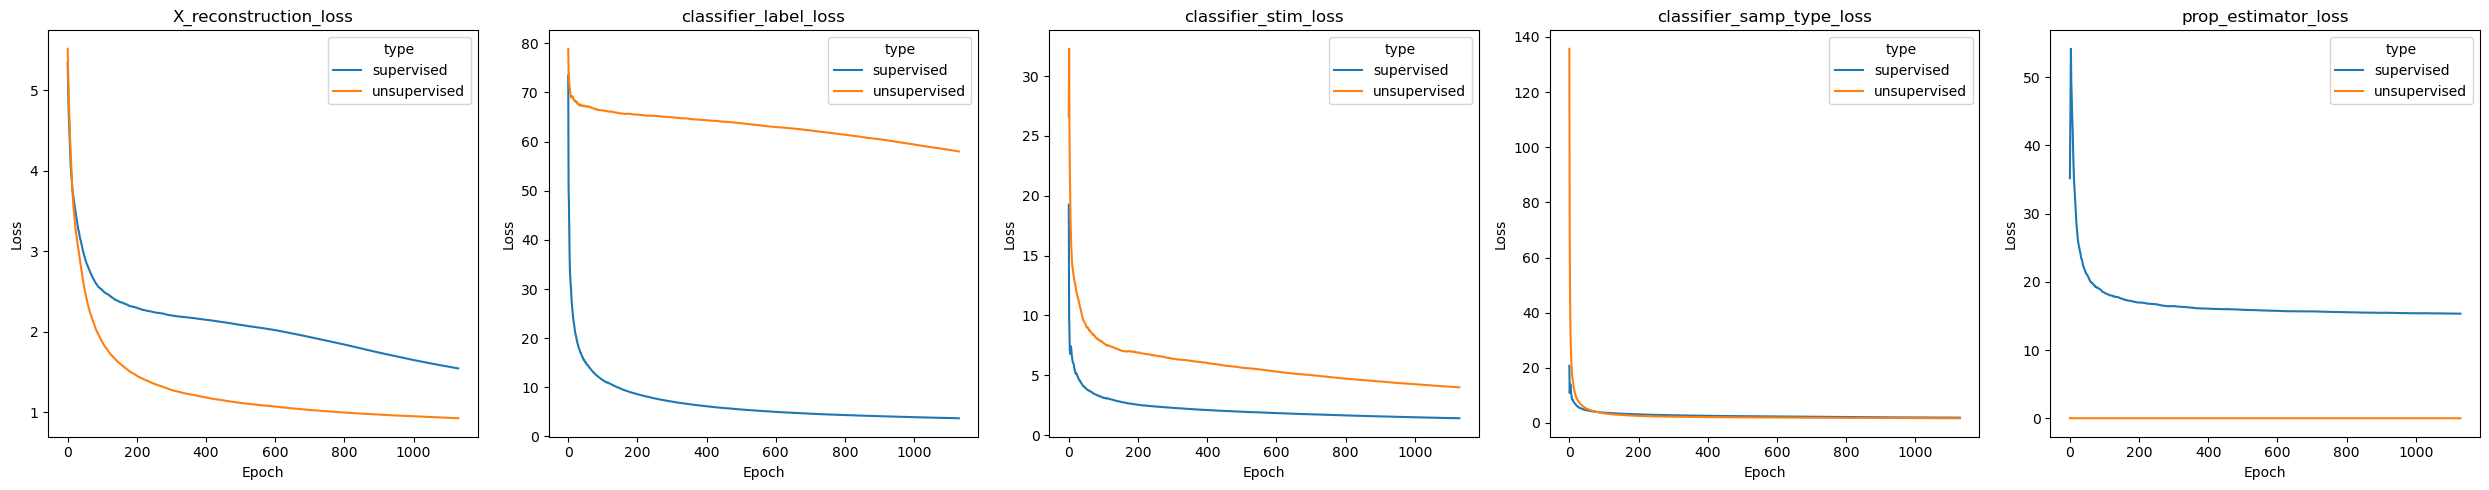

In [24]:
def simple_plot_loss(loss_df, show_plot=True, save_path=None):
    fig, axes = plt.subplots(1, 5, figsize=(25, 5), sharex=True)

    loss_columns = [
        'X_reconstruction_loss', 
        'classifier_label_loss', 
        'classifier_stim_loss', 
        'classifier_samp_type_loss', 
        'prop_estimator_loss'
    ]

    for ax, col in zip(axes, loss_columns):
        sns.lineplot(
            data=loss_df, 
            x='index', 
            y=col, 
            hue='type', 
            ax=ax
        )
        ax.set_title(col)
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Loss')

    plt.tight_layout()

    if save_path is not None:
        plt.savefig(save_path, bbox_inches='tight', dpi=300)

    if show_plot:
        plt.show()
    else:
        plt.close()

all_loss_df['index'] = all_loss_df.index.to_list()
simple_plot_loss(all_loss_df, save_path=None, show_plot=True)

### Saving BuDDI4 object

In [25]:
obj.save(
    directory='temp'
)

Saved model structure looks like this

In [26]:
print(os.listdir('temp'))

['decoder.weights.h5', 'samp_type_classifier.weights.h5', 'samp_type_encoder.weights.h5', 'stim_encoder.weights.h5', 'slack_encoder.weights.h5', 'stim_classifier.weights.h5', 'label_classifier.weights.h5', 'config.json', 'label_encoder.weights.h5', 'prop_estimator.weights.h5']


In [27]:
!rm -rf temp

### To load saved object and weights, do

In [28]:
# loaded_obj = BuDDI4.load(
#     directory='temp'
# )